## Description:

    Use DeSeq2 to identify OTUs that are correlated with inorganic N concentration


# Setting variables

In [3]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3'

# Init

In [2]:
%load_ext rpy2.ipython

In [6]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales",  "phyloseq", "dplyr", "tidyr", 
           "reshape2", "vegan")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.4’
[1] "BiocParallel"
[1] ‘1.8.1’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.14.0’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.2.0’
[1] "gridExtra"
[1] ‘2.2.1’
[1] "scales"
[1] ‘0.4.1’
[1] "phyloseq"
[1] ‘1.18.0’
[1] "dplyr"
[1] ‘0.5.0’
[1] "tidyr"
[1] ‘0.6.0’
[1] "reshape2"
[1] ‘1.4.2’
[1] "vegan"
[1] ‘2.4.1’


In [7]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [8]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


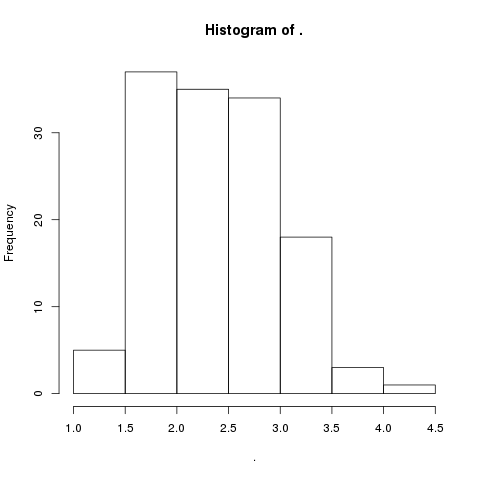

In [9]:
%%R
sample_data(physeq.Full)$InorganicN %>% log() %>% hist

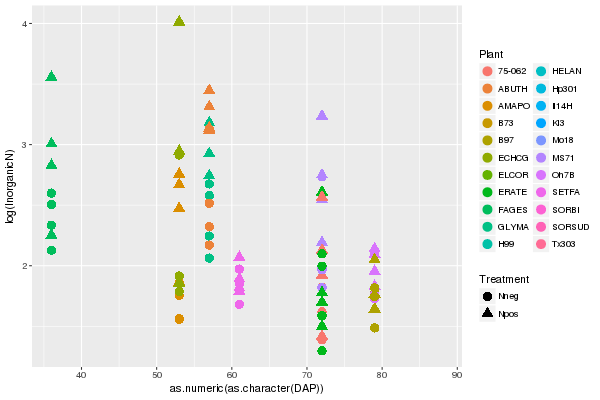

In [10]:
%%R -w 600 -h 400
sd = sample_data(physeq.Full)
sd = filter(sd, Plant != "BARE")
p = ggplot(sd, aes(x = as.numeric(as.character(DAP)), y = log(InorganicN), color = Plant, shape = Treatment)) + 
           geom_point(size = 4)
p 

In [11]:
%%R
sd %>% filter(InorganicN > 50) %>% .[,c("Plant", "Plot")]

  Plant Plot
1 ECHCG 1.24


### Notes:
* High inorganic N outlier will weight analysis.  Remove before proceeding. 

In [13]:
%%R

#Set DAP as factor
sample_data(physeq.Full)$DAP = factor(sample_data(physeq.Full)$DAP) 
sample_data(physeq.Full)$Rep = factor(sample_data(physeq.Full)$Rep) 
sample_data(physeq.Full)$DAP %>% levels

#sample_data(physeq.Full)$PlantRep = interaction(sample_data(physeq.Full)$Rep, sample_data(physeq.Full)$Plant)

# remove inorganic N outliers
p = subset_samples(physeq.Full, InorganicN < 50)
#p = subset_samples(physeq.Full, !is.na(InorganicN))

physeq.plant = subset_samples(p, Plant != "BARE")
physeq.bare = subset_samples(p, Plant == "BARE")

p = NULL

In [14]:
%%R
physeq.plant

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 84 samples ]
sample_data() Sample Data:       [ 84 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


## Create DeSeq2 object testing for inorganic N while controlling for plant

In [15]:
%%R

dds = phyloseq_to_deseq2(physeq.plant, ~Plant + log(InorganicN))
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(physeq.plant)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "InorgN"
        NR = DF

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: converting counts to integer mode

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: gene-wise dispersion estimates: 20 workers

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: final dispersion estimates, MLE betas: 20 workers

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/li

 [1] "Intercept"       "Plant75.062"     "PlantABUTH"      "PlantAMAPO"     
 [5] "PlantB97"        "PlantECHCG"      "PlantERATE"      "PlantFAGES"     
 [9] "PlantGLYMA"      "PlantMS71"       "PlantOh7B"       "PlantSETFA"     
[13] "log.InorganicN."


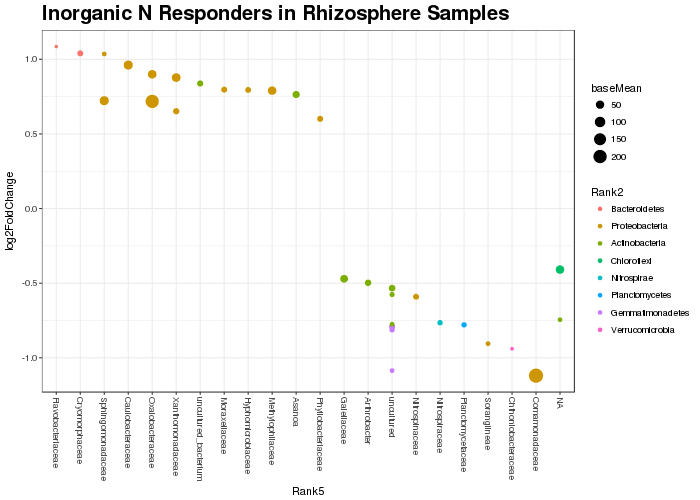

In [16]:
%%R -w 700 -h 500


sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

 

p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() + 
    ggtitle("Inorganic N Responders in Rhizosphere Samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       


p

In [17]:
%%R
paste(dim(sigtab)[1], "OTUs correlated with inorganic N concentration") %>% print

sigtab %>% 
    filter(log2FoldChange > 0) %>% 
    dim %>%
    .[1] %>%
    paste(.,"OTUs positively correlated with inorganic N concentration") %>% 
    print


sigtab %>% 
    filter(log2FoldChange < 0) %>% 
    dim %>%
    .[1] %>%
    paste(.,"OTUs negatively correlated with inorganic N concentration")%>% 
    print
 
sigtab %>% 
    filter(log2FoldChange < 0) %>% print

[1] "31 OTUs correlated with inorganic N concentration"
[1] "15 OTUs positively correlated with inorganic N concentration"
[1] "16 OTUs negatively correlated with inorganic N concentration"
     baseMean log2FoldChange     lfcSE      stat       pvalue        padj
1   53.245384     -0.4084517 0.1143557 -3.571765 3.545836e-04 0.036947975
2    5.376219     -1.0855173 0.2444750 -4.440198 8.987600e-06 0.005374585
3   16.123252     -0.7900934 0.2370669 -3.332787 8.598078e-04 0.049757911
4    9.925462     -0.8118271 0.2367709 -3.428745 6.063797e-04 0.041428888
5  237.777927     -1.1193100 0.2480444 -4.512539 6.405620e-06 0.005374585
6    5.967561     -0.9051376 0.2440945 -3.708144 2.087840e-04 0.026754184
7    2.612766     -0.9393266 0.2319705 -4.049336 5.136315e-05 0.013163641
8    9.521599     -0.7646658 0.2164511 -3.532742 4.112733e-04 0.036947975
9   14.837546     -0.5904819 0.1666668 -3.542889 3.957695e-04 0.036947975
10  39.100652     -0.4705226 0.1318108 -3.569681 3.574157e-04 0.036947

## Notes:
* Few OTUs respond to inorganic N concentration.  It is possible that the interaction between plant and N concentration is important
* Distribution is right skewed, so log transformation of inorganic N concentration is helpful


## Create DeSeq2 object testing for N treatment while controlling for plant
* using trimmed data set for which there is Inorganic N data

In [18]:
%%R

dds = phyloseq_to_deseq2(physeq.plant, ~Plant + Treatment)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(physeq.plant)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "Ntreat_a"
        NR = rbind(NR, DF)

 [1] "Intercept"     "Plant75.062"   "PlantABUTH"    "PlantAMAPO"   
 [5] "PlantB97"      "PlantECHCG"    "PlantERATE"    "PlantFAGES"   
 [9] "PlantGLYMA"    "PlantMS71"     "PlantOh7B"     "PlantSETFA"   
[13] "TreatmentNneg" "TreatmentNpos"


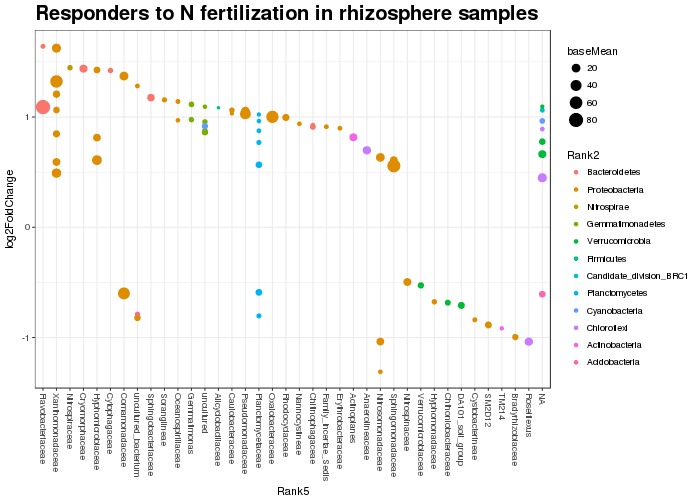

In [19]:
%%R -w 700 -h 500


sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

 
NtreatResp1_6 = DF
p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() + 
    ggtitle("Responders to N fertilization in rhizosphere samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       
p
    

In [20]:
%%R
paste(dim(sigtab)[1], "OTUs correlated with inorganic N concentration") %>% print

sigtab %>% 
    filter(log2FoldChange > 0) %>% 
    dim %>%
    .[1] %>%
    paste(.,"OTUs positively correlated with inorganic N concentration") %>% 
    print


sigtab %>% 
    filter(log2FoldChange < 0) %>% 
    dim %>%
    .[1] %>%
    paste(.,"OTUs negatively correlated with inorganic N concentration")%>% 
    print
 
sigtab %>% 
    filter(log2FoldChange < 0) %>% print

[1] "76 OTUs correlated with inorganic N concentration"
[1] "58 OTUs positively correlated with inorganic N concentration"
[1] "18 OTUs negatively correlated with inorganic N concentration"
    baseMean log2FoldChange     lfcSE      stat       pvalue         padj
1  17.238544     -1.0367120 0.2496438 -4.152765 3.284817e-05 0.0044616380
2   2.462856     -0.7865645 0.2407576 -3.267040 1.086784e-03 0.0478670391
3   8.065210     -0.6064833 0.1727170 -3.511428 4.457059e-04 0.0262714166
4  13.606409     -1.0362939 0.2131742 -4.861254 1.166443e-06 0.0004048853
5   1.763324     -1.3107385 0.2851450 -4.596744 4.291448e-06 0.0009196179
6  51.345652     -0.5995283 0.1639463 -3.656858 2.553254e-04 0.0194545519
7   2.391334     -0.8389109 0.2459696 -3.410629 6.481333e-04 0.0349097993
8   9.196437     -0.8855276 0.2486477 -3.561375 3.689181e-04 0.0233386902
9   3.545734     -0.6755076 0.2067826 -3.266753 1.087887e-03 0.0478670391
10  6.420651     -0.9954052 0.2058352 -4.835933 1.325224e-06 0.0004139

## Test N treatment effect in entire dataset


In [21]:
%%R
phy = subset_samples(physeq.Full, Plant != "BARE")
phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [22]:
%%R

dds = phyloseq_to_deseq2(phy, ~Plant + Treatment)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "Ntreat_b"
        NR = rbind(NR, DF)

 [1] "Intercept"     "Plant75.062"   "PlantABUTH"    "PlantAMAPO"   
 [5] "PlantB73"      "PlantB97"      "PlantECHCG"    "PlantELCOR"   
 [9] "PlantERATE"    "PlantFAGES"    "PlantGLYMA"    "PlantH99"     
[13] "PlantHELAN"    "PlantHp301"    "PlantIl14H"    "PlantKi3"     
[17] "PlantMo18"     "PlantMS71"     "PlantOh7B"     "PlantSETFA"   
[21] "PlantSORBI"    "PlantSORSUD"   "PlantTx303"    "TreatmentNneg"
[25] "TreatmentNpos"


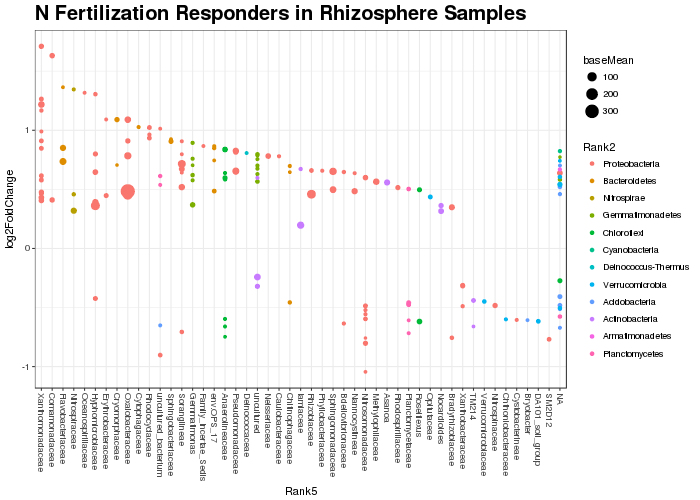

In [23]:
%%R -w 700 -h 500


sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

NtreatResp1_8 = DF

p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() + 
    ggtitle("N Fertilization Responders in Rhizosphere Samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       
p
    

In [24]:
%%R
paste(dim(sigtab)[1], "OTUs shift in response to nitrogen fertilization") %>% print

sigtab %>% 
    filter(log2FoldChange > 0) %>% 
    dim %>%
    .[1] %>%
    paste(.,"OTUs enriched in fertilized plots") %>% 
    print


sigtab %>% 
    filter(log2FoldChange < 0) %>% 
    dim %>%
    .[1] %>%
    paste(.,"OTUs declining in abundance in fertilized plots")%>% 
    print

sigtab %>% 
    filter(log2FoldChange < 0 & OTU == "OTU.7") %>% print

[1] "163 OTUs shift in response to nitrogen fertilization"
[1] "118 OTUs enriched in fertilized plots"
[1] "45 OTUs declining in abundance in fertilized plots"
 [1] baseMean       log2FoldChange lfcSE          stat           pvalue        
 [6] padj           Rank1          Rank2          Rank3          Rank4         
[11] Rank5          Rank6          Rank7          Rank8          OTU           
[16] Test          
<0 rows> (or 0-length row.names)


# Make heatmap of OTUs that are responders in N

In [28]:
%%R
head(NR)

          baseMean log2FoldChange     lfcSE        stat     pvalue padj
OTU.4087 0.1685120    -0.02509207 0.1360610 -0.18441786 0.85368566   NA
OTU.2009 0.7144240    -0.07719871 0.2439297 -0.31647937 0.75163868   NA
OTU.5899 0.2775791     0.07259113 0.2074549  0.34991282 0.72640413   NA
OTU.4181 0.2164358    -0.04653268 0.2071134 -0.22467252 0.82223405   NA
OTU.3052 0.3665593    -0.01442746 0.2199029 -0.06560834 0.94768965   NA
OTU.1890 1.0368276    -0.44810821 0.2481433 -1.80584442 0.07094265   NA
            Rank1         Rank2                Rank3                     Rank4
OTU.4087 Bacteria           TM6 uncultured_bacterium                      <NA>
OTU.2009 Bacteria           TM6 uncultured_bacterium                      <NA>
OTU.5899 Bacteria Acidobacteria                32-21      uncultured_bacterium
OTU.4181 Bacteria Elusimicrobia          Lineage_IIa      uncultured_bacterium
OTU.3052 Bacteria Elusimicrobia          Lineage_IIa uncultured_soil_bacterium
OTU.1890 Bacteria Elus

## what does base mean represent

In [40]:
%%R
NR %>%
    filter(Test == "Ntreat_a") %>%
    .$baseMean %>%
    sum()

[1] 26205.46


In [35]:
%%R
temp = NR
temp$direction = ifelse(temp$log2FoldChange >= 0, "Pos", "Neg")
temp = filter(temp, padj < 0.05)
temp %>% head

   baseMean log2FoldChange     lfcSE      stat       pvalue        padj
1 53.245384     -0.4084517 0.1143557 -3.571765 3.545836e-04 0.036947975
2  5.376219     -1.0855173 0.2444750 -4.440198 8.987600e-06 0.005374585
3 16.123252     -0.7900934 0.2370669 -3.332787 8.598078e-04 0.049757911
4  9.925462     -0.8118271 0.2367709 -3.428745 6.063797e-04 0.041428888
5 15.452774      1.0400467 0.2460737  4.226565 2.372856e-05 0.007094839
6  2.474040      1.0858992 0.2413704  4.498891 6.830889e-06 0.005374585
     Rank1            Rank2            Rank3             Rank4
1 Bacteria      Chloroflexi           KD4-96              <NA>
2 Bacteria Gemmatimonadetes Gemmatimonadales Gemmatimonadaceae
3 Bacteria Gemmatimonadetes Gemmatimonadales Gemmatimonadaceae
4 Bacteria Gemmatimonadetes Gemmatimonadales Gemmatimonadaceae
5 Bacteria    Bacteroidetes    Flavobacteria  Flavobacteriales
6 Bacteria    Bacteroidetes    Flavobacteria  Flavobacteriales
              Rank5                Rank6               

In [39]:
%%R
colnames(temp)

 [1] "baseMean"       "log2FoldChange" "lfcSE"          "stat"          
 [5] "pvalue"         "padj"           "Rank1"          "Rank2"         
 [9] "Rank3"          "Rank4"          "Rank5"          "Rank6"         
[13] "Rank7"          "Rank8"          "OTU"            "Test"          
[17] "direction"     


In [47]:
%%R
theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
}

In [54]:
%%R
temp$Test %>% str

 chr [1:194] "Ntreat_b" "Ntreat_b" "Ntreat_b" "Ntreat_b" ...


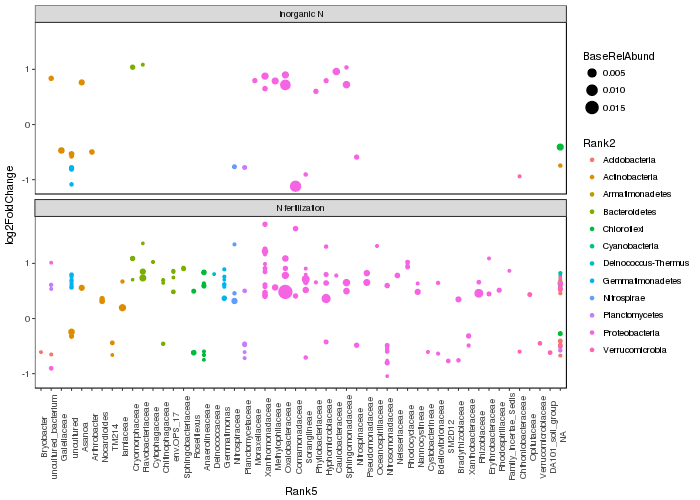

In [58]:
%%R -h 500 -w 700

NR$direction = ifelse(NR$log2FoldChange >= 0, "Pos", "Neg")
temp = filter(NR, padj < 0.05 & Test != "Ntreat_a")
temp = arrange(temp, Rank2)
temp = mutate(temp, BaseRelAbund = ifelse(Test == "Ntreat_b", baseMean/19493.08, baseMean/ 26205.46))
#temp = mutate(temp, TestLabel = ifelse(Test == "Ntreat_b"))
temp$Rank5 = factor(temp$Rank5, levels=temp$Rank5[order(temp$Rank2)], ordered=TRUE)
temp$Test = as.factor(temp$Test)
levels(temp$Test) = c("Inorganic N", "N fertilization")
ggplot(temp, aes(x = Rank5, y = log2FoldChange, color = Rank2, size = BaseRelAbund)) +
geom_point() + 
facet_wrap(~ Test, ncol = 1)+
theme_pub()+
theme(axis.text.x = element_text(angle = 90))

# Write table of rhizosphere N responders to file

In [189]:
%%R
write.table(NR, file = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/Nresponders.txt', sep = "\t")


## Format tables

# Test inorganic N concentration in bare soil samples

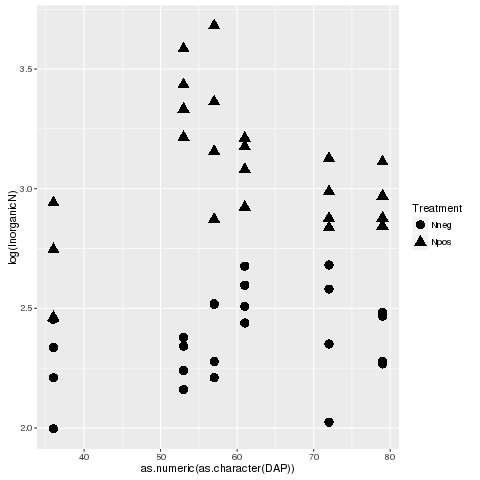

In [110]:
%%R
sd = sample_data(physeq.bare)
p = ggplot(sd, aes(x = as.numeric(as.character(DAP)), y = log(InorganicN), shape = Treatment)) + 
           geom_point(size = 4)
p 

## Test for InorganicN while controlling for date

In [115]:
%%R

dds = phyloseq_to_deseq2(physeq.bare, ~DAP + Rep + log(InorganicN))
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds, independentFiltering = TRUE, parallel = TRUE)

supp = tax_table(physeq.bare)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

 [1] "Intercept"       "DAP36"           "DAP53"           "DAP57"          
 [5] "DAP61"           "DAP72"           "DAP79"           "Rep1"           
 [9] "Rep2"            "Rep3"            "Rep4"            "log.InorganicN."


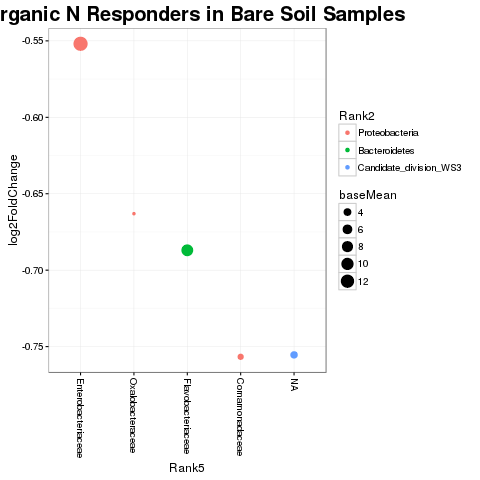

In [116]:
%%R
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

 

p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() + 
    ggtitle("Inorganic N Responders in Bare Soil Samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       
p

In [117]:
%%R
sigtab = filter(DF, padj < 0.05)

paste(dim(sigtab)[1], "OTUs respond to inorganic N concentration in bare soil samples")

[1] "5 OTUs respond to inorganic N concentration in bare soil samples"


## Test N treatment effect in bare soil


In [118]:
%%R
dds = phyloseq_to_deseq2(physeq.bare, ~DAP + Rep + Treatment)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds, independentFiltering = TRUE, parallel = TRUE)

supp = tax_table(physeq.bare)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

 [1] "Intercept"     "DAP36"         "DAP53"         "DAP57"        
 [5] "DAP61"         "DAP72"         "DAP79"         "Rep1"         
 [9] "Rep2"          "Rep3"          "Rep4"          "TreatmentNneg"
[13] "TreatmentNpos"


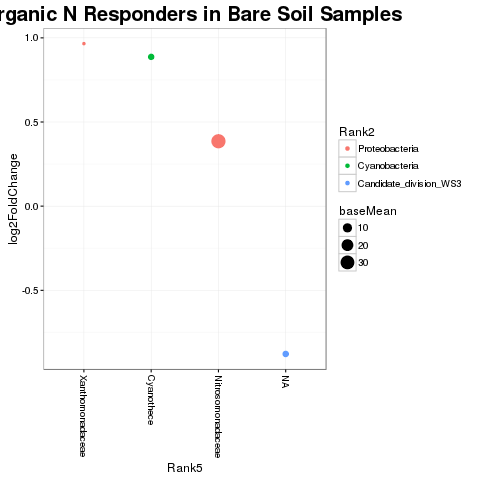

In [119]:
%%R
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

 

p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() + 
    ggtitle("Inorganic N Responders in Bare Soil Samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       
p
    

In [121]:
%%R
sigtab = filter(DF, padj < 0.05)
paste(dim(sigtab)[1], "OTUs respond to N treatment in bare soil samples")

[1] "4 OTUs respond to N treatment in bare soil samples"


In [122]:
%%R
sigtab

   baseMean log2FoldChange      lfcSE      stat       pvalue        padj
1  3.636690      0.8870216 0.19319561  4.591314 4.404650e-06 0.007233904
2  1.319885      0.9656571 0.18303240  5.275881 1.321202e-07 0.000650956
3 32.370588      0.3859195 0.09219816  4.185762 2.842111e-05 0.035007707
4  3.720877     -0.8779052 0.18449437 -4.758439 1.950962e-06 0.004806194
     Rank1                  Rank2                Rank3            Rank4
1 Bacteria          Cyanobacteria          SubsectionI          FamilyI
2 Bacteria         Proteobacteria  Gammaproteobacteria  Xanthomonadales
3 Bacteria         Proteobacteria   Betaproteobacteria Nitrosomonadales
4 Bacteria Candidate_division_WS3 uncultured_bacterium             <NA>
              Rank5                Rank6                Rank7 Rank8       OTU
1        Cyanothece uncultured_bacterium                 <NA>  <NA>   OTU.621
2  Xanthomonadaceae          Silanimonas uncultured_bacterium  <NA>  OTU.6279
3 Nitrosomonadaceae         Nitrosospira 